# Peter Moss Acute Myeloid & Lymphoblastic Leukemia AI Research Project
## Acute Lymphoblastic Leukemia Arduino Nano 33 BLE Classifier

![Acute Lymphoblastic Leukemia Arduino Nano 33 BLE Classifier](../assets/images/project-banner.jpg)

# Introduction

The **Acute Lypmhoblastic Leukemia Arduino Nano 33 BLE Sense Classifier** is an experiment to explore how low powered microcontrollers, specifically the Arduino Nano 33 BLE Sense, can be used to detect Acute Lymphoblastic Leukemia. The Arduino Nano 33 BLE Sense is the latest Arduino Board  which supports  Tensorflow Lite, allowing machine learning on Arduino. 

The motivation for this project was to explore how low powered devices such as Arduino can be used to detect Acute Lymphoblastic Leukemia. The project will be submitted to the Tensorflow For Microcontroller Challenge and the Eyes on Edge: tinyML Vision Challenge.

# DISCLAIMER

_This project should be used for research purposes only. The purpose of the project is to show the potential of Artificial Intelligence for medical support systems such as diagnostic systems._

_Although the model is accurate and shows good results both on paper and in real world testing, it is trained on a small amount of data and needs to be trained on larger datasets to really evaluate it's accuracy._

_Developers that have contributed to this repository have experience in using Artificial Intelligence for detecting certain types of cancer. They are not doctors, medical or cancer experts._

# Software

To use this project you will need to install the following software:

- Conda
- Intel® oneAPI AI Analytics Toolkit
- Jupyter Notebooks
- NBConda 
- Mlxtend
- Pillow
- Opencv
- Scipy
- Scikit Image
- Scikit Learn

# Installation

Before you can begin this tutorial you need to follow the [installation guide](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/blob/main/docs/installation/ubuntu.md) to install the relevant software and setup your environment.

# Import Modules

In [1]:
import cv2
import os
import pathlib
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from numpy.random import seed
from PIL import Image
from scipy import ndimage
from skimage import transform as tm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from mlxtend.plotting import plot_confusion_matrix

# Set Global Variables

In [2]:
decay = 1e-6
dim = 100
epochs = 150
lr = 1e-4
rotations = 10
seed_amount = 2
test_split = 0.255
val_steps = 10
valid_files = [
    ".jpg"
]

modelDir = "../model/"
dataDir = modelDir + "data/"
testDataDir = dataDir + "test/"
trainDataDir = dataDir + "train/"

model_path = modelDir + "all_nano_33_ble_sense.json"
weights_path = modelDir + "all_nano_33_ble_sense.h5"
tflite_model_path = modelDir + "all_nano_33_ble_sense.tflite"
c_array_model_path = modelDir + "all_nano_33_ble_sense.cc"

testData = [
    "Im006_1.jpg",
    "Im020_1.jpg",
    "Im024_1.jpg",
    "Im026_1.jpg",
    "Im028_1.jpg",
    "Im031_1.jpg",
    "Im035_0.jpg",
    "Im041_0.jpg",
    "Im047_0.jpg",
    "Im053_1.jpg",
    "Im057_1.jpg",
    "Im060_1.jpg",
    "Im063_1.jpg",
    "Im069_0.jpg",
    "Im074_0.jpg",
    "Im088_0.jpg",
    "Im095_0.jpg",
    "Im099_0.jpg",
    "Im101_0.jpg",
    "Im106_0.jpg"
]

seed(seed_amount)
random.seed(seed_amount)

# Data

## ALL-IDB
You need to be granted access to use the Acute Lymphoblastic Leukemia Image Database for Image Processing dataset. You can find the application form and information about getting access to the dataset on [this page](https://homes.di.unimi.it/scotti/all/#download) as well as information on how to contribute back to the project [here](https://homes.di.unimi.it/scotti/all/results.php). If you are not able to obtain a copy of the dataset please feel free to try this tutorial on your own dataset, we would be very happy to find additional AML & ALL datasets.

## ALL_IDB1
In this project, [ALL-IDB1](https://homes.di.unimi.it/scotti/all/#datasets) is used, one of the datsets from the Acute Lymphoblastic Leukemia Image Database for Image Processing dataset. We will use data augmentation to increase the amount of training and testing data we have.

## Data Preprocessing 

In this part of the notebook we will create the methods used for processing the data ready for training.

### Testing Data

First we need to remove the test data that we will use for testing the classifier later from the training data folder. We remove these images before the training so that the classifier does not learn them during training. The following cell provides the function to move the test data to the **model/data/test** folder: 

In [3]:
def remove_testing():
    """ Removes the testing images from the dataset. """

    for img in testData:
        original = trainDataDir+img
        destination = testDataDir+img
        pathlib.Path(original).rename(destination)
        print(original + " moved to " + destination)
        cv2.imwrite(destination, cv2.resize(cv2.imread(destination),
                                            (dim, dim)))
        print("Resized " + destination)

### Augmentation

We will create an augmented dataset based on the [Leukemia Blood Cell Image Classification Using Convolutional Neural Network](http://www.ijcte.org/vol10/1198-H0012.pdf "Leukemia Blood Cell Image Classification Using Convolutional Neural Network") by T. T. P. Thanh, Caleb Vununu, Sukhrob Atoev, Suk-Hwan Lee, and Ki-Ryong Kwon.

In [4]:
def resize(path, dim):
    """ Resizes an image to the provided dimensions (dim). """

    return cv2.resize(cv2.imread(path), (dim, dim))

In [5]:
def grayscale(data):
    """ Creates a grayscale copy. """

    gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    return np.dstack([gray, gray, gray]).astype(np.float32)/255.

In [6]:
def equalize_hist(data):
    """ Creates a histogram equalized copy. """

    img_to_yuv = cv2.cvtColor(data, cv2.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result.astype(np.float32)/255.

In [7]:
def reflection(data):
    """ Creates a reflected copy. """

    return cv2.flip(data, 0).astype(np.float32)/255., cv2.flip(data, 1).astype(np.float32)/255.

In [8]:
def gaussian(data):
    """ Creates a gaussian blurred copy. """

    return ndimage.gaussian_filter(data, sigma=5.11).astype(np.float32)/255.

In [9]:
def translate(data):
    """ Creates transformed copy. """

    cols, rows, chs = data.shape

    return cv2.warpAffine(data, np.float32([[1, 0, 84], [0, 1, 56]]), (rows, cols),
                          borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162)).astype(np.float32)/255.

In [10]:
def rotation(data):
    """ Creates a rotated copy. """

    cols, rows, chs = data.shape

    rand_deg = random.randint(-180, 180)
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), rand_deg, 0.70)
    rotated = cv2.warpAffine(data, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                             borderValue=(144, 159, 162))

    return rotated.astype(np.float32)/255.

In [11]:
def shear(data):
    """ Creates a sheared copy. """

    at = tm.AffineTransform(shear=0.5)
    return tm.warp(data, inverse_map=at)

In [12]:
def preprocess():
    """ Preprocesses the data. """
    
    # Read all data from training dir
    data_dir = pathlib.Path(trainDataDir)
    train_data = list(data_dir.glob('*.jpg'))

    count = 0
    neg_count = 0
    pos_count = 0

    data = []
    labels = []
    temp = []

    # Loop through training data
    for rimage in train_data:
        fpath = str(rimage)
        fname = os.path.basename(rimage)
        label = 0 if "_0" in fname else 1

        # Resize image
        image = resize(fpath, dim)

        if image.shape[2] == 1:
            image = np.dstack(
                [image, image, image])

        temp.append(image.astype(np.float32)/255.)

        data.append(image.astype(np.float32)/255.)
        labels.append(label)

        # Grayscale
        data.append(grayscale(image))
        labels.append(label)

        # Histogram Equalization
        data.append(equalize_hist(image))
        labels.append(label)
        
        # Reflection
        horizontal, vertical = reflection(image)
        data.append(horizontal)
        labels.append(label)

        data.append(vertical)
        labels.append(label)

        # Gaussian Blur
        data.append(gaussian(image))
        labels.append(label)

        # Tranlsation
        data.append(translate(image))
        labels.append(label)

        # Shear
        data.append(shear(image))
        labels.append(label)
        
        # Rotation
        for i in range(0, rotations):
            data.append(rotation(image))
            labels.append(label)
            if "_0" in fname:
                neg_count += 1
            else:
                pos_count += 1
            count +=1

        if "_0" in fname:
            neg_count += 8
        else:
            pos_count += 8
        count +=8

    train_arr = np.asarray(temp)

    print("Augmented data size: " + str(count))
    print("Negative data size: " + str(neg_count))
    print("Positive data size: " + str(pos_count))
    
    return data, labels, train_arr

## Data Preparation

In [13]:
def shuffle_data(data, labels):
    """ Shuffles the data and labels. """

    data, labels = shuffle(
        data, labels, random_state=seed_amount)
    
    return data, labels

In [14]:
def convert_data(data):
    """ Converts the training data to a numpy array. """

    data = np.array(data)
    print("Augmented data shape: " + str(data.shape))
    
    return data

In [15]:
def encode_labels(labels):
    """ One Hot Encodes the labels. """

    encoder = OneHotEncoder(categories='auto')

    labels = np.reshape(labels, (-1, 1))
    labels = encoder.fit_transform(labels).toarray()
    print("Labels shape: " + str(labels.shape))
    
    return labels

## Data Split  

In [16]:
def get_split(data, labels):
    """ Splits the data and labels creating training and validation datasets. """

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_split, random_state=seed_amount)

    print("Training data:     " + str(X_train.shape))
    print("Training labels:   " + str(y_train.shape))
    print("Validation data:   " + str(X_test.shape))
    print("Validation labels: " + str(y_test.shape))
    
    return X_train, X_test, y_train, y_test

## Process & Prepare Data

In [17]:
remove_testing()

../model/data/train/Im006_1.jpg moved to ../model/data/test/Im006_1.jpg
Resized ../model/data/test/Im006_1.jpg
../model/data/train/Im020_1.jpg moved to ../model/data/test/Im020_1.jpg
Resized ../model/data/test/Im020_1.jpg
../model/data/train/Im024_1.jpg moved to ../model/data/test/Im024_1.jpg
Resized ../model/data/test/Im024_1.jpg
../model/data/train/Im026_1.jpg moved to ../model/data/test/Im026_1.jpg
Resized ../model/data/test/Im026_1.jpg
../model/data/train/Im028_1.jpg moved to ../model/data/test/Im028_1.jpg
Resized ../model/data/test/Im028_1.jpg
../model/data/train/Im031_1.jpg moved to ../model/data/test/Im031_1.jpg
Resized ../model/data/test/Im031_1.jpg
../model/data/train/Im035_0.jpg moved to ../model/data/test/Im035_0.jpg
Resized ../model/data/test/Im035_0.jpg
../model/data/train/Im041_0.jpg moved to ../model/data/test/Im041_0.jpg
Resized ../model/data/test/Im041_0.jpg
../model/data/train/Im047_0.jpg moved to ../model/data/test/Im047_0.jpg
Resized ../model/data/test/Im047_0.jpg
.

In [18]:
data, labels, train_arr = preprocess()
data, labels = shuffle_data(data, labels)
data = convert_data(data)
labels = encode_labels(labels)
X_train, X_test, y_train, y_test = get_split(data, labels)

Augmented data size: 1584
Negative data size: 882
Positive data size: 702
Augmented data shape: (1584, 100, 100, 3)
Labels shape: (1584, 2)
Training data:     (1180, 100, 100, 3)
Training labels:   (1180, 2)
Validation data:   (404, 100, 100, 3)
Validation labels: (404, 2)


## Data Visualization  

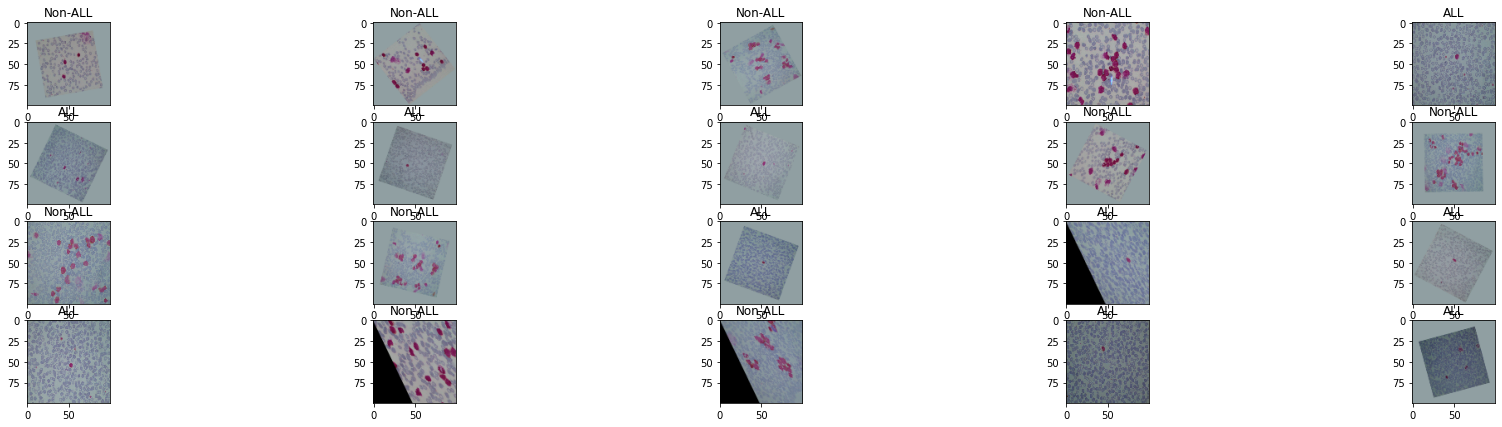

In [19]:
y = np.argmax(labels, axis=-1)
fig, ax = plt.subplots(4,5, figsize=(30,7))
for i in range(0,20):
    ax[i//5, i%5].imshow(data[i])
    if y[i]==1:
        ax[i//5, i%5].set_title("Non-ALL")
    else:
        ax[i//5, i%5].set_title("ALL")

# Network
## Build Network  

In [20]:
def build_network():
    """ Builds the network. """

    tf_model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1:])),
        tf.keras.layers.AveragePooling2D(
            pool_size=(2, 2), strides=None, padding='valid'),
        tf.keras.layers.Conv2D(30, (5, 5), strides=1,
            padding="valid", activation='relu'),
        tf.keras.layers.DepthwiseConv2D(30, (1, 1),
            padding="valid", activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2),
        tf.keras.layers.Activation('softmax')
    ],
    "AllANBS")
    tf_model.summary()
    
    return tf_model
    
tf_model = build_network()

Model: "AllANBS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 30)        2280      
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 17, 17, 30)        27030     
_________________________________________________________________
flatten (Flatten)            (None, 8670)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 17342     
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 46,652
Trainable params: 46,652
Non-trainable params: 0
_______________________________________________________

# Model
## Train Model 

In [21]:
def train(X_train, y_train, X_test, y_test):
    """ Trains the model. """
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3, 
                                                verbose=0, 
                                                mode='auto', 
                                                restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, decay = decay)

    tf_model.compile(optimizer=optimizer, loss='binary_crossentropy',
                    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall'),
                            tf.keras.metrics.AUC(name='auc') ])

    history = tf_model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            validation_steps=val_steps,
                            epochs=epochs, callbacks=[callback])
    return tf_model, history

tf_model, history = train(X_train, y_train, X_test, y_test)

Epoch 1/150
37/37 [==============================] - 14s 368ms/step - loss: 0.6799 - acc: 0.5780 - precision: 0.5780 - recall: 0.5780 - auc: 0.6030 - val_loss: 0.6582 - val_acc: 0.6163 - val_precision: 0.6163 - val_recall: 0.6163 - val_auc: 0.7203
Epoch 2/150
37/37 [==============================] - 14s 372ms/step - loss: 0.6144 - acc: 0.7059 - precision: 0.7059 - recall: 0.7059 - auc: 0.7586 - val_loss: 0.5855 - val_acc: 0.7698 - val_precision: 0.7698 - val_recall: 0.7698 - val_auc: 0.8046
Epoch 3/150
37/37 [==============================] - 14s 376ms/step - loss: 0.5429 - acc: 0.7636 - precision: 0.7636 - recall: 0.7636 - auc: 0.8129 - val_loss: 0.5400 - val_acc: 0.7649 - val_precision: 0.7649 - val_recall: 0.7649 - val_auc: 0.8224
Epoch 4/150
37/37 [==============================] - 14s 384ms/step - loss: 0.5034 - acc: 0.7763 - precision: 0.7763 - recall: 0.7763 - auc: 0.8383 - val_loss: 0.5036 - val_acc: 0.7649 - val_precision: 0.7649 - val_recall: 0.7649 - val_auc: 0.8497
Epoch 5/

## Save Model 

In [22]:
def save_model_as_json(tf_model):
    """ Saves the model as JSON """

    with open(model_path, "w") as file:
        file.write(tf_model.to_json())

save_model_as_json(tf_model)

## Save Weights

In [23]:
def save_weights(tf_model):
    """ Saves the model weights """

    tf_model.save_weights(weights_path)
    print("Weights saved " + weights_path)
    
save_weights(tf_model)

Weights saved ../model/all_nano_33_ble_sense.h5


## Convert To TFLite Model

In [24]:
def convert_to_tflite(tf_model, train_arr):
    """ Converts to TFLite model """

    def representative_dataset():

        for input_value in tf.data.Dataset.from_tensor_slices(train_arr).batch(1).take(100):
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    return converter.convert()

tflite_model= convert_to_tflite(tf_model, train_arr)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpa4sjwr4b/assets


## Save TFLite Model

In [25]:
def save_tflite_model(tflite_model):
    """ Saves the TFLite model """

    with open(tflite_model_path, "wb") as file:
        file.write(tflite_model)

    print("Model TFLite saved " + tflite_model_path)
    
save_tflite_model(tflite_model)

Model TFLite saved ../model/all_nano_33_ble_sense.tflite


## Convert To C Array Model

In [26]:
def convert_to_c_array():
    """ Converts the TFLite model to C array"""
    
    os.system('xxd -i  ' + tflite_model_path + ' > ' + c_array_model_path)
    print("C array model created " + c_array_model_path)
    
convert_to_c_array()

C array model created ../model/all_nano_33_ble_sense.cc


## Evaluate Model  

In [27]:
def evaluate(tf_model, X_test, y_test):
    """ Evaluates the model """

    metrics = tf_model.evaluate(
        X_test, y_test, verbose=0)
    for name, value in zip(tf_model.metrics_names, metrics):
        print("Metrics: " + name + " " + str(value))
        
evaluate(tf_model, X_test, y_test)

Metrics: loss 0.20655369758605957
Metrics: acc 0.9331682920455933
Metrics: precision 0.9331682920455933
Metrics: recall 0.9331682920455933
Metrics: auc 0.9755906462669373


### Predictions

In [28]:
def predictions(tf_model, X_train, X_test):
    """ Gets predictions. """

    train_preds = tf_model.predict(X_train)
    test_preds = tf_model.predict(X_test)
    
    return train_preds, test_preds
    
train_preds, test_preds = predictions(tf_model, X_train, X_test)

## Model Metrics 

### Accuracy

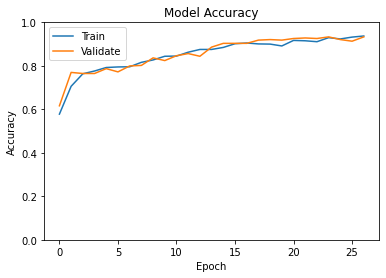

<Figure size 432x288 with 0 Axes>

In [29]:
def plot_accuracy(history):
    """ Plots the accuracy. """

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim((0, 1))
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/accuracy.png')
    plt.show()
    plt.clf()
    
plot_accuracy(history)

### Loss

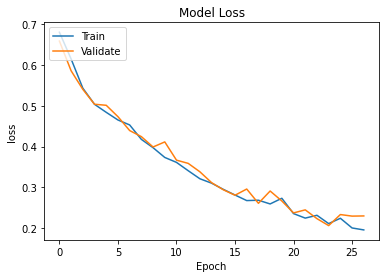

<Figure size 432x288 with 0 Axes>

In [30]:
def plot_loss(history):
    """ Plots the loss. """

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/loss.png')
    plt.show()
    plt.clf()
    
plot_loss(history)

### Precision

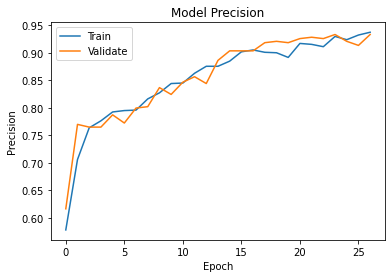

<Figure size 432x288 with 0 Axes>

In [31]:
def plot_precision(history):
    """ Plots the precision. """

    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/precision.png')
    plt.show()
    plt.clf()
    
plot_precision(history)

### AUC

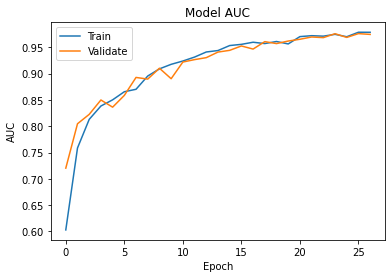

<Figure size 432x288 with 0 Axes>

In [32]:
def plot_auc(history):
    """ Plots the AUC. """

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/auc.png')
    plt.show()
    plt.clf()
    
plot_auc(history)

### Recall

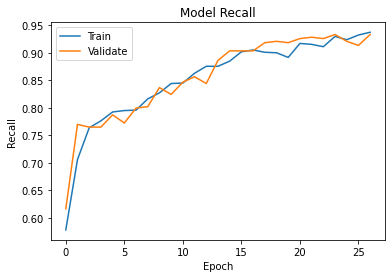

<Figure size 432x288 with 0 Axes>

In [33]:
def plot_recall(history):
    """ Plots the recall. """

    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.savefig('../model/plots/recall.png')
    plt.show()
    plt.clf()
    
plot_recall(history)

## Confusion Matrix

Confusion Matrix: [[217   4]
 [ 23 160]]



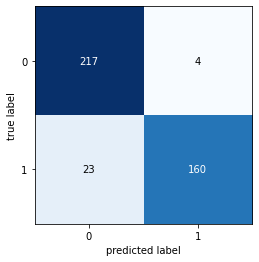

<Figure size 432x288 with 0 Axes>

In [34]:
def confusion_matrix_plot(y_test, test_preds):
    """ Plots the confusion matrix. """
    
    matrix = confusion_matrix(y_test.argmax(axis=1),
                              test_preds.argmax(axis=1))

    print("Confusion Matrix: " + str(matrix))
    print("")

    plot_confusion_matrix(conf_mat=matrix)
    plt.savefig('../model/plots/confusion-matrix.png')
    plt.show()
    plt.clf()
    
    return matrix
    
matrix = confusion_matrix_plot(y_test, test_preds)

## Figures Of Merit

In [35]:
def figures_of_merit(X_test, matrix):
    """ Calculates/prints the figures of merit.

    https://homes.di.unimi.it/scotti/all/
    """

    test_len = len(X_test)

    TP = matrix[1][1]
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]

    TPP = (TP * 100)/test_len
    FPP = (FP * 100)/test_len
    FNP = (FN * 100)/test_len
    TNP = (TN * 100)/test_len

    specificity = TN/(TN+FP)

    misc = FP + FN
    miscp = (misc * 100)/test_len

    print("True Positives: " + str(TP) + "(" + str(TPP) + "%)")
    print("False Positives: " + str(FP) + "(" + str(FPP) + "%)")
    print("True Negatives: " + str(TN) + "(" + str(TNP) + "%)")
    print("False Negatives: " + str(FN) + "(" + str(FNP) + "%)")

    print("Specificity: " + str(specificity))
    print("Misclassification: " + str(misc) + "(" + str(miscp) + "%)")

figures_of_merit(X_test, matrix)

True Positives: 160(39.603960396039604%)
False Positives: 4(0.9900990099009901%)
True Negatives: 217(53.71287128712871%)
False Negatives: 23(5.693069306930693%)
Specificity: 0.9819004524886877
Misclassification: 27(6.683168316831683%)


# Testing

In [36]:
def load():
    """ Loads the model """

    with open(model_path) as file:
        m_json = file.read()

    model = tf.keras.models.model_from_json(m_json)
    model.load_weights(weights_path)

    model.summary()
    
    return model

model = load()

Model: "AllANBS"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 30)        2280      
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 17, 17, 30)        27030     
_________________________________________________________________
flatten (Flatten)            (None, 8670)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 17342     
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 46,652
Trainable params: 46,652
Non-trainable params: 0
_______________________________________________________

In [37]:
def reshape(img):
    """ Reshapes an image. """

    dx, dy, dz = img.shape
    input_data = img.reshape((-1, dx, dy, dz))
    input_data = input_data / 255.0

    return input_data

In [38]:
def predict(model, img):
    """ Gets a prediction for an image. """

    preds = model.predict(img)
    pred = np.argmax(preds, axis=-1)

    return pred

In [39]:
def test(model):
    """ Test mode

    Loops through the test directory and classifies the images.
    """

    files = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    totaltime = 0

    for testFile in os.listdir(testDataDir):
        if os.path.splitext(testFile)[1] in valid_files:
            files += 1
            fileName = testDataDir + testFile

            start = time.time()
            img = cv2.imread(fileName).astype(np.float32)
            print("Loaded test image " + fileName)

            img = reshape(img)

            prediction = predict(model, img)
            end = time.time()
            benchmark = end - start
            totaltime += benchmark

            msg = ""
            if prediction == 1 and "_1." in testFile:
                tp += 1
                msg = "Acute Lymphoblastic Leukemia correctly detected (True Positive) in " + str(benchmark) + " seconds."
            elif prediction == 1 and "_0." in testFile:
                fp += 1
                msg = "Acute Lymphoblastic Leukemia incorrectly detected (False Positive) in " + str(benchmark) + " seconds."
            elif prediction == 0 and "_0." in testFile:
                tn += 1
                msg = "Acute Lymphoblastic Leukemia correctly not detected (True Negative) in " + str(benchmark) + " seconds."
            elif prediction == 0 and "_1." in testFile:
                fn += 1
                msg = "Acute Lymphoblastic Leukemia incorrectly not detected (False Negative) in " + str(benchmark) + " seconds."
            print(msg)

    print("Images Classified: " + str(files))
    print("True Positives: " + str(tp))
    print("False Positives: " + str(fp))
    print("True Negatives: " + str(tn))
    print("False Negatives: " + str(fn))
    print("Total Time Taken: " + str(totaltime))
    
test(model)

Loaded test image ../model/data/test/Im063_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.057331085205078125 seconds.
Loaded test image ../model/data/test/Im028_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.033262014389038086 seconds.
Loaded test image ../model/data/test/Im106_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.032111167907714844 seconds.
Loaded test image ../model/data/test/Im101_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.03342151641845703 seconds.
Loaded test image ../model/data/test/Im024_1.jpg
Acute Lymphoblastic Leukemia correctly detected (True Positive) in 0.03428959846496582 seconds.
Loaded test image ../model/data/test/Im074_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negative) in 0.036455631256103516 seconds.
Loaded test image ../model/data/test/Im035_0.jpg
Acute Lymphoblastic Leukemia correctly not detected (True Negativ

# Conclusion  

Here we trained a deep learning model for Acute Lymphoblastic Leukemia detection utilizing Intel® Optimization for Tensorflow* from the Intel® oneAPI AI Analytics Toolkit to optimize and accelarate training. We introduced a 6 layer deep learning model and applied data augmentation to increase the training data. 

We trained our model with a target of 150 epochs and used early stopping to avoid overfitting. The model trained for 27 epochs resulting in a fairly good fit, and accuracy/precision/recall and AUC are satisfying. In addition the model reacts well during testing classifying each of the twenty unseen test images correctly. 

# Contributing
Asociación de Investigacion en Inteligencia Artificial Para la Leucemia Peter Moss encourages and welcomes code contributions, bug fixes and enhancements from the Github community.

Please read the [CONTRIBUTING](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/blob/main/CONTRIBUTING.md "CONTRIBUTING") document for a full guide to forking our repositories and submitting your pull requests. You will also find our code of conduct in the [Code of Conduct](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/blob/main/CODE-OF-CONDUCT.md) document.

## Contributors
- [Adam Milton-Barker](https://www.leukemiaairesearch.com/association/volunteers/adam-milton-barker "Adam Milton-Barker") - [Asociación de Investigacion en Inteligencia Artificial Para la Leucemia Peter Moss](https://www.leukemiaresearchassociation.ai "Asociación de Investigacion en Inteligencia Artificial Para la Leucemia Peter Moss") President/Founder & Lead Developer, Sabadell, Spain

&nbsp;

# Versioning
We use [SemVer](https://semver.org/) for versioning.

&nbsp;

# License
This project is licensed under the **MIT License** - see the [LICENSE](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/blob/main/LICENSE "LICENSE") file for details.

&nbsp;

# Bugs/Issues
We use the [repo issues](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/issues "repo issues") to track bugs and general requests related to using this project. See [CONTRIBUTING](https://github.com/AMLResearchProject/ALL-Arduino-Nano-33-BLE-Sense-Classifier/blob/main/CONTRIBUTING.md "CONTRIBUTING") for more info on how to submit bugs, feature requests and proposals.